## Exercise 6 - Image classification

In this notebook you will experiment with unsupervised and supervised statistical algorithms for image classification. 


### How to use this Jupyter Notebook

The Jupyter Notebook is composed by a series of *cells*, each one containing either Python code or text instructions.
The text instruction that you are currently reading here are inside a *text cell*.

To run a cell, just click on it and then press the `Run` button at the top of the screen, or use the shortcut `Shift - Enter`.

You will not need to run *text cells*.
Only cells containing Python code need to be run.
Make sure that you will execute *code cells* in descending order, from the beginning of this Jupyter Notebook to its end. 
Since this Jupyter Notebook runs online, you will not need to install anything on your personal computer.

If you prefer, and/or if you already have a Python installation on your personal computer, you can also download this notebook from [this GitHub repository](https://github.com/ltelab/RS2022/tree/main/exercise_6) and run it locally.
In this case, you will need to install the packages listed in the [`environment.yml`](https://github.com/ltelab/RS2022/blob/main/environment.yml) file using `conda env create -f environment.yml`.

You are not required to have prior Python programming knowledge.
All you will have to do is to modify the value of some quantities (or *variables*) to achieve the result requested by each section of the exercise.
You will need to interpret these results to answer the questions of the exercise.
However, if you want to experiment with the code provided, feel free to edit the code: the changes that you make will not overwrite the original copy of the notebook.
When logged in through EPFL's Noto platform, your changes will be saved to your session.

**Variables that will need to be modified will be defined in UPPERCASE and preceeded by a comment indicating the request**

A comment is a line of code preceeded by the symbol *#*.
For example:

    # This is a comment

A variable that you will be required to modify will look like the following example:
    
    # Modify the value of the following variable
    VARIABLE_TO_MODIFY = 2

To modify the variable, change the value after the = sign. For example:

    VARIABLE_TO_MODIFY = 3

will change the value of *VARIABLE_TO_MODIFY* from *2* to *3*.

### Note memory consumption

Across the exercise, we provided several code cells that "reset" the notebook, clearing up some RAM memory space.
In theory, those should be sufficient to execute the exercise on EPFL Noto.
If you still encounter a high memory consumption, we suggest two approaches:
- Clear all current outputs by clicking on `Cell` -> `All Output` -> `Clear`
- Re-start the kernel by clicking on `Kernel` -> `Restart & Clear Output`.

In both cases, you will need to continue with the exercise from the cell that loads the python libraries immediately precceding the part of the exercise you will be working on.
By *loading the libraries* we mean the code cells containing lines of codes such as:

    import numpy as np
    

#### Start the exercise by running the next cell: it will import the libraries needed for the exercise.

In [133]:
import os 
import glob 
import warnings
import rioxarray
import rasterio 
import sklearn 
import colorcet
import matplotlib
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.colors as c
import copy
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.size']=15

## 1. Introduction

In the first part of the exercise (sections 2-4) we will look at the region of Canberra (Australia) to analyze the local vegetation and land cover. 
For this section we are using data from the Sentinel-2 satellite.
We first focus our analyis on the spectral signatures of various land covers. Then we will apply principal component analysis (PCA) to perform further exploratory data analysis (EDA) and then we will apply an unsupervised classification algorithm (k-means) to perform land cover classification. 

In the second part of the exercise (section 5) we will shift the focus to the area of Lucerne, where we will be using Landsat data. 
There, we will investigate different algorithm for supervised classification of images.

## 2. Spectral signatures of land cover

Spectral signatures show the specific reflectance of different electromagnetic wavelengths on selected land surfaces. 

In the following cell, you will first display the true color image (Sentinel 2) of the region of Canberra.
By looking at this image, one can identify several different land cover types.\2
In this section we will be using the following categories:
- forest
- grassland
- bare soil
- water
- cities
- clouds *(which is not per se a land cover type, but will be treated as such since it is present in the satellite imagery)*

*Note: some land cover type can be tricky to identify just from this image. 
Feel free to use the internet (e.g. google earth) if you have doubts.*


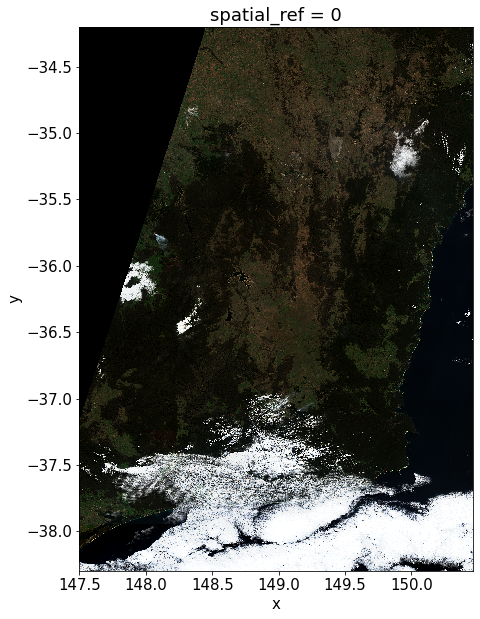

In [134]:
data_dir = "Data/Australia_2019"

bands_fpattern =  "*(Raw).tiff"
true_color_fname = "2019-05-15-00_00_2019-05-15-23_59_Sentinel-2_L2A_True_color.tiff"

band_fpaths = sorted(glob.glob(os.path.join(data_dir, bands_fpattern)))
true_color_fpath = os.path.join(data_dir, true_color_fname)

# Load true color 
da_true_color = xr.open_dataset(true_color_fpath, engine="rasterio",default_name="true_color")['true_color']
da_true_color = da_true_color.compute()
fig = plt.figure(figsize=(10,10))
da_true_color.plot.imshow()
plt.gca().set_aspect('equal', adjustable='box')

The following cell loads and displays the images of the same region in each of the 12 bands that we will be using during the rest of the exercise (no input required from you)

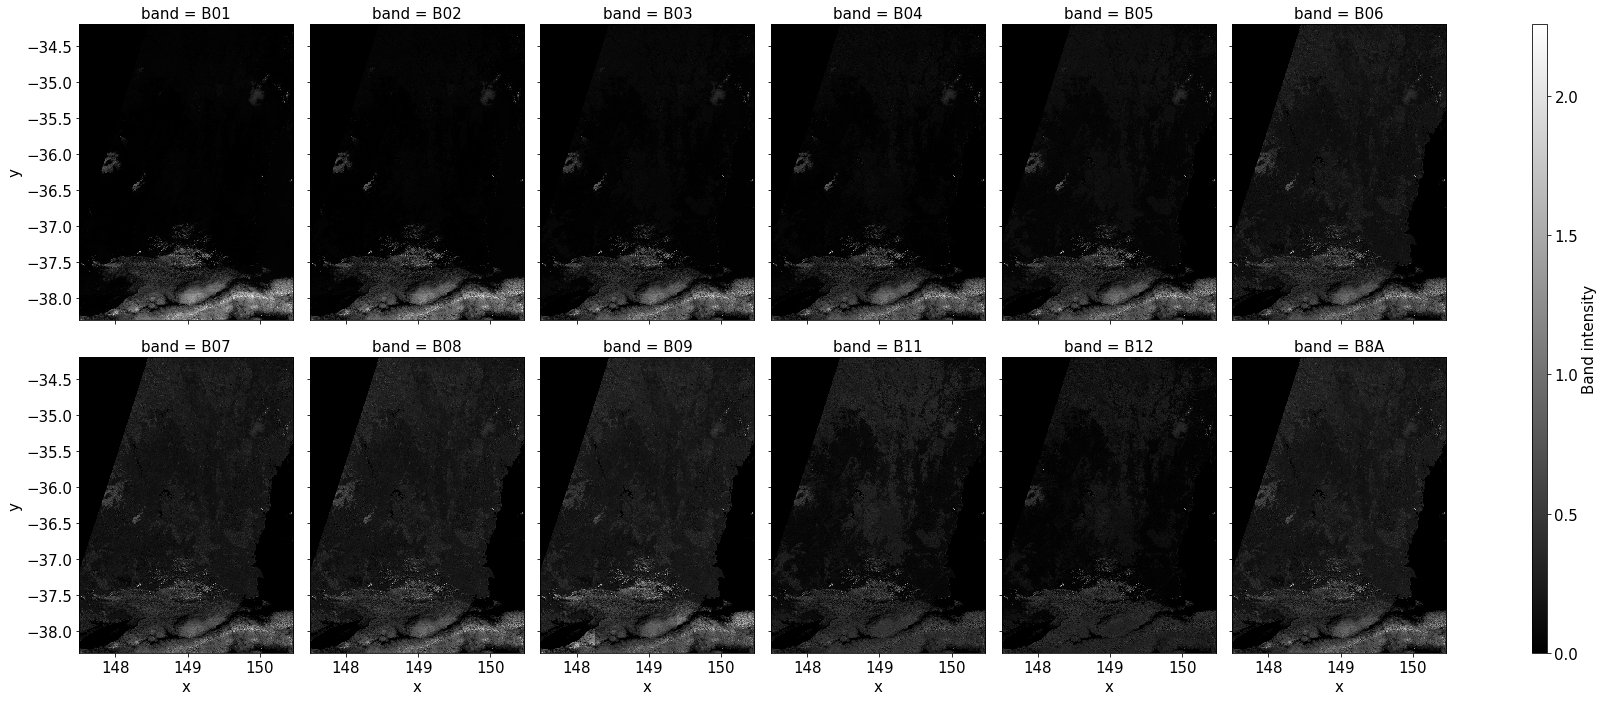

In [135]:
# Load all bands
bands = [os.path.basename(fpath).split("_")[6] for fpath in band_fpaths]
da_bands = xr.open_mfdataset(band_fpaths, engine="rasterio", concat_dim="band", combine="nested")['band_data']
da_bands = da_bands.assign_coords({'band': bands})
da_bands = da_bands.compute()
ds_bands = da_bands.to_dataset(dim='band')


# Plot all bands 
p = da_bands.plot.imshow(col="band", col_wrap=6, figsize=(25,10), cmap="gray",cbar_kwargs={
                          "orientation": "vertical",
                          "shrink": 1,
                          "aspect": 40,
                          "label": "Band intensity",
                         })
for ax in p.axes.flatten():
    ax.set_aspect('equal', adjustable='box')

The following cell loads and prepares the data for the next steps.

In [136]:
# Here we load the scene classification image
labels_fname = "2019-05-15-00_00_2019-05-15-23_59_Sentinel-2_L2A_Scene_classification_map.tiff" 
labels_fpath = os.path.join(data_dir, labels_fname)

da_labels_RGB = xr.open_dataset(labels_fpath, engine="rasterio", default_name="labels")['labels']
da_labels_RGB = da_labels_RGB.compute()
x = da_labels_RGB['x']
y = da_labels_RGB['y']

# Retrieve labels id 
da_labels = (da_labels_RGB[0,:,:]*255+1000*da_labels_RGB[1,:,:]*255+1000000*da_labels_RGB[2,:,:]*255).astype('int')#da_stack.unstack('id').transpose('y','x')
label_list = np.unique(da_labels)
for i in range(1,12):
    da_labels = da_labels.where(da_labels!=label_list[i],i)

col_dict={0:"black",
          1:"red",
          2:"saddlebrown",
          3:"green",
          4: 'dimgrey',
          5:'khaki',
          6: 'darkgray',
          7:'lightgray',
          8:'blue',
          9:'violet',
          10:'deepskyblue',
          11:'white'}

# Define colormap and colorbar settings 
cm = c.ListedColormap([col_dict[i] for i in col_dict.keys()])
labels = np.array(["No data", "Saturated or defective pixel", "Cloud shadows", 
                   "Vegetation","Dark features/Shadows", "Not-vegetated", "Unclassified", "Cloud medium probability",
                    "Water", "Snow or ice", "Thin cirrus","Cloud high probability"])
norm_bins = np.arange(-1,12)+.5
norm = matplotlib.colors.BoundaryNorm(norm_bins, len(labels))
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

In the following cell, you will have to identify pixels corresponding to each of the 6 afore-mentioned land cover types.

To do this, we display once again the true color image (on the left). To help you choose the pixels, you can also use the **scene classification product** (displayed on the right): this is an additional satellite product containing some basic scene classifications (e.g. clouds, water etc) - but it does not contain exactly the same categories as the ones we are interested in. It can however help you discriminate some of them.

In order to select pixels from each land cover type, you will have to change the values of the corresponding variables below (e.g. `X_forest, Y_forest`).
The initial values are set randomly and DO NOT correspond to the actual land type, for example the value of `X_forest` and `Y_forest` initially set might be in a water area.
With the following lines, define the location of pixels corresponding to each type of land cover. Feel free to play around with the values until you are pleased with the location of each pixel.


Below we print the class (according to the "scene classification" image) corresponding to each of the selected pixels:

Scene classification of chosen "Forest" pixel:  No data
Scene classification of chosen "Grassland" pixel:  Vegetation
Scene classification of chosen "Bare soil" pixel:  No data
Scene classification of chosen "Water" pixel:  Cloud high probability
Scene classification of chosen "Cities" pixel:  Vegetation
Scene classification of chosen "Clouds" pixel:  Not-vegetated




Text(0, 0.5, 'Latitude (°)')

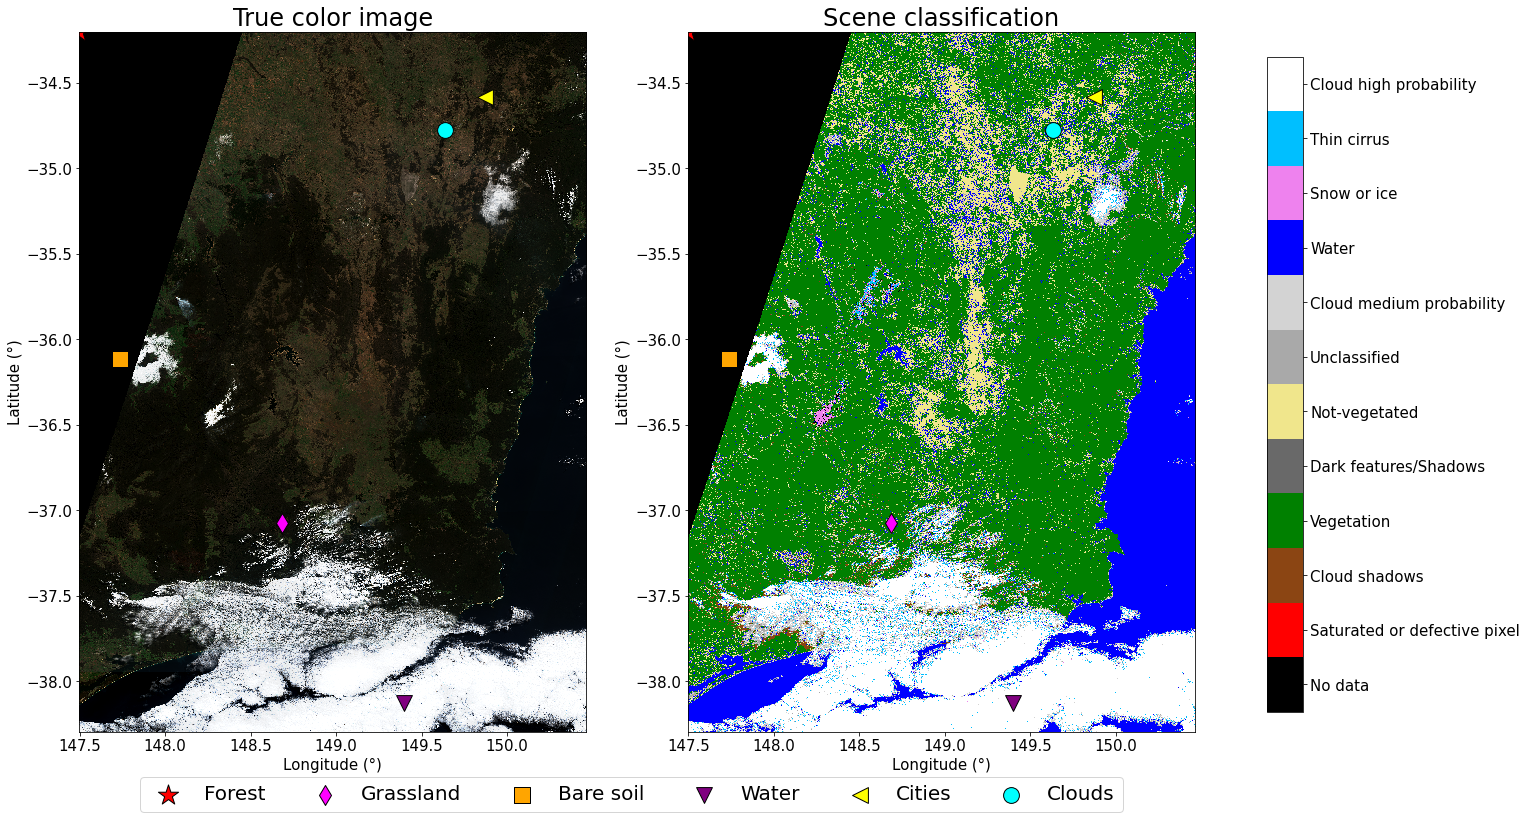

In [137]:
# ------------------------------------------------------------------------
### EACH OF THE FOLLOWING VALUES SHOULD BE SET UNTIL YOU ARE PLEASED WITH IT
## Note that here you choose the INDEX of the pixel and not directly its spatial coordinates (lat/lon). 
## For example, X=0, Y=0 corresponds to the top left of the image i.e. lat ~ -34 degrees and lon ~147.5 degrees.

X_FOREST = 0       # marker='*',color='red'
Y_FOREST = 0
X_GRASSLAND = 500     # marker='d',color='magenta'
Y_GRASSLAND = 1500
X_BARE_SOIL = 100     # marker='v',color='purple'
Y_BARE_SOIL = 1000   
X_WATER = 800         # marker='v',color='purple' 
Y_WATER = 2050 
X_CITIES = 1000       # marker='<',color='yellow'
Y_CITIES = 200
X_CLOUDS = 900        # marker='o',color='cyan'
Y_CLOUDS = 300
# ------------------------------------------------------------------------

print('Below we print the class (according to the "scene classification" image) corresponding to each of the selected pixels:\n')
print('Scene classification of chosen "Forest" pixel: ',labels[da_labels[Y_FOREST,X_FOREST].data])
print('Scene classification of chosen "Grassland" pixel: ',labels[da_labels[Y_GRASSLAND,X_GRASSLAND].data])
print('Scene classification of chosen "Bare soil" pixel: ',labels[da_labels[Y_BARE_SOIL,X_BARE_SOIL].data])
print('Scene classification of chosen "Water" pixel: ',labels[da_labels[Y_WATER,X_WATER].data])
print('Scene classification of chosen "Cities" pixel: ',labels[da_labels[Y_CITIES,X_CITIES].data])
print('Scene classification of chosen "Clouds" pixel: ',labels[da_labels[Y_CLOUDS,X_CLOUDS].data])
print('\n')

# Display the land cover 
fig,axs = plt.subplots(1,2,figsize=(20,13))

da_true_color.plot.imshow(ax=axs[0])
im=da_labels.plot.imshow(ax=axs[1],cmap=cm,norm=norm,add_colorbar=0)
tickz = norm_bins[:-1]+ .5
axs[0].set_aspect('equal', adjustable='box')
axs[1].set_aspect('equal', adjustable='box')
cbar_ax = fig.add_axes([.95, 0.15, 0.025, 0.7])
cb = fig.colorbar(im, cax=cbar_ax,format=fmt, ticks=tickz)

for ax in axs:
    ax.scatter(x[X_FOREST],y[Y_FOREST],s=450,marker='*',color='red',edgecolor='black',label='Forest')
    ax.scatter(x[X_GRASSLAND],y[Y_GRASSLAND],s=200,marker='d',color='magenta',edgecolor='black',label='Grassland')
    ax.scatter(x[X_BARE_SOIL],y[Y_BARE_SOIL],s=250,marker='s',color='orange',edgecolor='black',label='Bare soil')
    ax.scatter(x[X_WATER],y[Y_WATER],s=250,marker='v',color='purple',edgecolor='black',label='Water')
    ax.scatter(x[X_CITIES],y[Y_CITIES],s=250,marker='<',color='yellow',edgecolor='black',label='Cities')
    ax.scatter(x[X_CLOUDS],y[Y_CLOUDS],s=250,marker='o',color='cyan',edgecolor='black',label='Clouds')
_=axs[0].legend(ncol=6,bbox_to_anchor=(.1,-.05),loc='upper left',fontsize=20)

axs[0].set_title('True color image',fontsize=24)
_ = axs[1].set_title('Scene classification',fontsize=24)
axs[0].set_xlabel('Longitude (°)')
axs[1].set_xlabel('Longitude (°)')
axs[0].set_ylabel('Latitude (°)')
axs[1].set_ylabel('Latitude (°)')

The following code displays the spectral signature of the selected pixels across all bands (i.e. for each of the chosen pixels, the value at this location for each of the bands). 

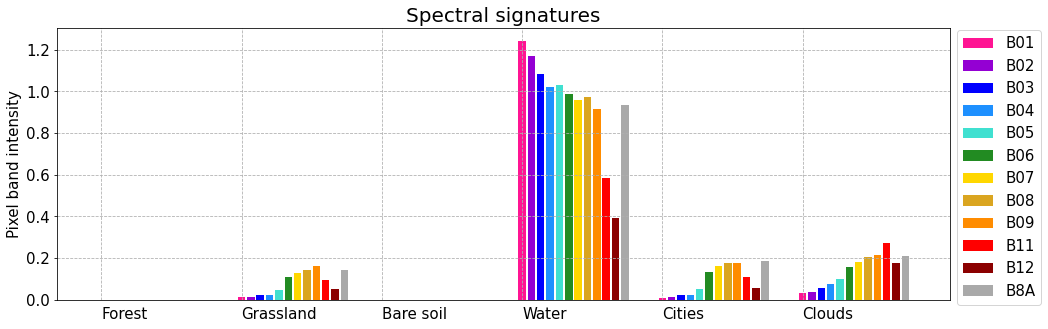

In [138]:
fig = plt.figure(figsize=(16,5))
band_list = []
color_list = ['deeppink','darkviolet','blue','dodgerblue','turquoise','forestgreen','gold','goldenrod','darkorange','red','darkred','darkgray']
for i in range(12):
    plt.bar(i,da_bands[i,Y_FOREST,X_FOREST].values,color=color_list[i],label=da_bands.band[i].to_numpy())
    plt.bar(i+15,da_bands[i,Y_GRASSLAND,X_GRASSLAND].values,color=color_list[i])
    plt.bar(i+30,da_bands[i,Y_BARE_SOIL,X_BARE_SOIL].values,color=color_list[i])
    plt.bar(i+45,da_bands[i,Y_WATER,X_WATER].values,color=color_list[i])
    plt.bar(i+60,da_bands[i,Y_CITIES,X_CITIES].values,color=color_list[i])
    plt.bar(i+75,da_bands[i,Y_CLOUDS,X_CLOUDS].values,color=color_list[i])
plt.grid(linestyle='--')
plt.gca().tick_params(top=False,
               bottom=False,
               left=True,
               right=False,
               labelleft=True,
               labelbottom=True)
plt.legend(bbox_to_anchor=[1.0,1.02],loc='upper left')
plt.gca().set_ylabel('Pixel band intensity')
_ =plt.xticks([0,15,30,45,60,75],labels=['Forest','Grassland','Bare soil','Water','Cities','Clouds'],ha='left')
_=plt.title('Spectral signatures',fontsize=20)

##### Investigate the differences in reflectance of the land surface covers
(You can look at the online documentation of the satellite bands https://www.satimagingcorp.com/satellite-sensors/other-satellite-sensors/sentinel-2a/)

> **Question 1**: Briefly discuss the spectral signature of each of the 6 land surface covers.


## 2. Principal component analysis (PCA)
In this section we will perform a PCA on the tabularized version of the satellite image. To this end, we first reshape the image tensor to a table, where rows correspond to image pixels and columns correspond to the pixel bands. 

PCA is a method that forms linear combinations between the input variables to derive (PC) components that
contribute most to the variability in the dataset. 
The resulting linear combinations are ranked in the order of their contribution to the overall variability.

In [139]:
### Data preprocessing 
# Merge all data into xr.Dataset
ds_bands = da_bands.to_dataset("band")
ds_full = ds_bands.copy()

# Conversion to pandas.DataFrame 
df_full = ds_full.to_dataframe()
df_full = df_full.drop(columns="spatial_ref")

print(df_full)

                          B01     B02     B03     B04     B05     B06     B07  \
y          x                                                                    
-34.203673 147.498135  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
           147.500508  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
           147.502881  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
           147.505254  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
           147.507627  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
...                       ...     ...     ...     ...     ...     ...     ...   
-38.295447 150.452578  0.5842  0.5264  0.4738  0.4381  0.4415  0.4178  0.4060   
           150.454951  0.6551  0.5383  0.4940  0.4682  0.4770  0.4623  0.4588   
           150.457324  0.6435  0.5994  0.5768  0.5623  0.5571  0.5371  0.5255   
           150.459697  0.4146  0.3559  0.3072  0.2719  0.2673  0.2512  0.2425   
           150.462070  0.497

Before we investigate the results of the PCA, take a look at the sentinel bands (i.e. what are their wavelengths/frequencies - for example here:  https://www.satimagingcorp.com/satellite-sensors/other-satellite-sensors/sentinel-2a/) and see, if you can find groups of similar bands.

> **Question 2**: How many groups of similar bands do you see (based on online documentation, etc.)? To which regions of the electromagnetic spectrum do these correspond?



We now look at the **correlation matrix**, which contains the correlations between all different bands. In the following cell, this matrix is printed (with its numerical value) and then plotted to allow for a more visual analysis.

The diagonal is equal to unity since the correlation of a band with itself is always 1.

          B01       B02       B03       B04       B05       B06       B07  \
B01  1.000000  0.980021  0.974913  0.969917  0.955374  0.866492  0.820077   
B02  0.980021  1.000000  0.997206  0.992702  0.978610  0.892777  0.845756   
B03  0.974913  0.997206  1.000000  0.998099  0.990642  0.918895  0.876211   
B04  0.969917  0.992702  0.998099  1.000000  0.994011  0.921566  0.879470   
B05  0.955374  0.978610  0.990642  0.994011  1.000000  0.955165  0.921440   
B06  0.866492  0.892777  0.918895  0.921566  0.955165  1.000000  0.994867   
B07  0.820077  0.845756  0.876211  0.879470  0.921440  0.994867  1.000000   
B08  0.798444  0.833833  0.863910  0.865460  0.908053  0.987755  0.994316   
B09  0.804323  0.793938  0.822165  0.827216  0.869771  0.933075  0.936893   
B11  0.685918  0.725034  0.766322  0.788503  0.834746  0.873597  0.871871   
B12  0.692002  0.728428  0.764243  0.789087  0.821719  0.820841  0.808247   
B8A  0.775074  0.800692  0.835363  0.840490  0.889645  0.983575  0.996377   

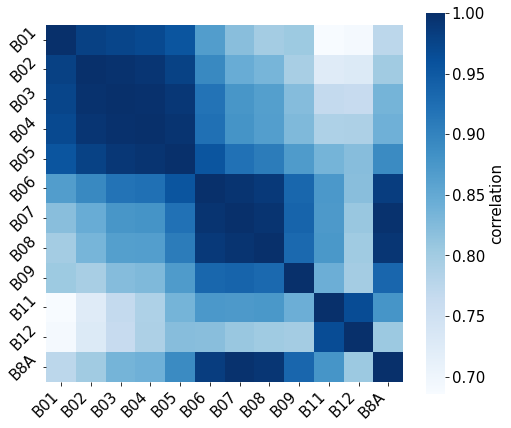

In [140]:
#### Compute correlation matrix 
corrMatrix = df_full[bands].corr()
print (corrMatrix)
print('\n')
# Display correlation matrix
f, ax = plt.subplots(figsize =(8, 7)) 
ax = sns.heatmap(
    corrMatrix, 
    #vmin=-1, vmax=1, center=0,
    cmap='Blues',
    # linewidths = 0.1, # for white border of each cell 
    square=True,
    annot=False,
    cbar_kws={'label': 'correlation'})
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=45,
    horizontalalignment='right')
plt.show()

> **Question 3**: What can you see? Are there any high correlations between the bands? How does this compare to your answer to question 2?

After this analysis of the bands and their correlations, we now perform the actual PCA.

In [141]:
# First, normalize the data to [0-1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler = scaler.fit(df_full[bands])
X_norm = scaler.transform(df_full[bands])

# Then run PCA
from sklearn.decomposition import PCA 
pca = PCA(n_components=len(bands))
_=pca.fit(X_norm)

# Retrieve PCA latent componenents
X_latent = pca.transform(X_norm)
df_latent = pd.DataFrame(X_latent, index = df_full.index)
ds_latent = df_latent.to_xarray()

We now look at the eigenvectors (principal components). 
Each of these vectors contains the weights of the original variables (here the satellite bands) 
in the linear combination that constitutes the components.

This depicts how much of each band is contained in each principal component. Larger values 
(in absolute) mean larger contributions of that band to the component. 
Eigen vector 1 corresponds to the first principal component, etc.\
The cell below prints the first component (with index 0 in python indexing)

In [142]:
first_component = pca.components_[0]
print('The first component reads:\n PC1 = ',first_component)

The first component reads:
 PC1 =  [0.34015968 0.31104094 0.30173123 0.2946173  0.30321234 0.29366058
 0.28655136 0.2954158  0.33898693 0.2087537  0.16520196 0.27634224]


> **Question 4**: Which band contributes the most to component 1? How about the other bands?

Now we take a look at `explained variance_` parameter, i.e. the Eigen values.
It contains information about the relative importance of every component. 
The larger the Eigen value of a component, the more variability (and information) it contains from the original data, thus contributing to the overall variability of the data. 

When using the `explained_variance_ratio_` parameter, we look at what *proportion* of the total variability does each principal component contribute. 

The following cell prints these values and displays them as a plot.


The Eigen values are:
 [0.0989 0.0073 0.0022 0.0014 0.0002 0.0001 0.0001 0.     0.     0.
 0.     0.    ]


The relative contributions of each principal component to the variance are:
 [0.897 0.066 0.02  0.012 0.002 0.001 0.001 0.    0.    0.    0.    0.   ]




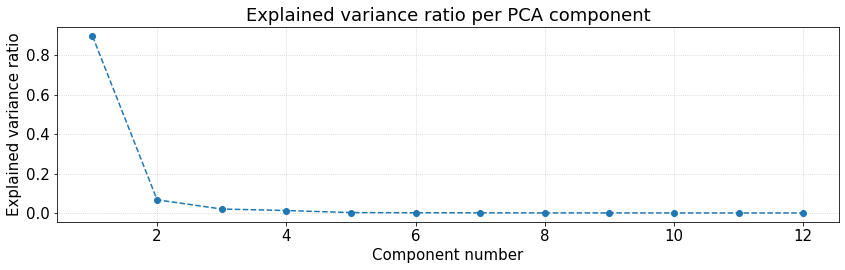

In [143]:
# Printing variance explained by each component
eigenvalues = pca.explained_variance_
print('The Eigen values are:\n', eigenvalues.round(4))
print('\n')

proportion_variance = pca.explained_variance_ratio_
print('The relative contributions of each principal component to the variance are:\n',proportion_variance.round(3))
print('\n')

# Plotting variance explained by each component
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
ax.grid(ls=':', c='gray', alpha=0.4)
ax.plot(np.arange(1,13),proportion_variance, ls='--', marker='o', c='tab:blue')
ax.set_xlabel('Component number')
ax.set_ylabel('Explained variance ratio')
ax.set_title('Explained variance ratio per PCA component')
plt.tight_layout()

> **Question 5**: Which proportion of the variance is represented by the components 1, 2 and 3 individually? And by the three components together?

> **Question 6**. Consider the importance of the PCs and the contribution of the bands to the PCs.
If you had to choose only 3 bands, which ones would you choose? Explain your choice.

In the following cell, we perform the inverse PCA transform by relying only on three of the principal components (PCs). This means that we reconstruct approximations of the images (for each band) based on the results of the PCA, and by selecting only three of the obtained PCs.

Based on the results of the PCA and the previous questions, **which PCs would you choose to reconstruct most accurately the original images?** Implement your choice by defining the index of the principal components `PC_a`, `PC_b` and `PC_c` in the next cell.

**Note**: Be careful, in python indexing starts at 0. So if you choose to use principal component 5 you should set for example `PC_a = 4`

*The next lines of code reconstruct the images using the three components (which you specify as `PC_a`, `PC_b` and `PC_c`). It then displays this reconstructed signal (one image for each channel) as well as the difference between original signal and reconstructed signal*

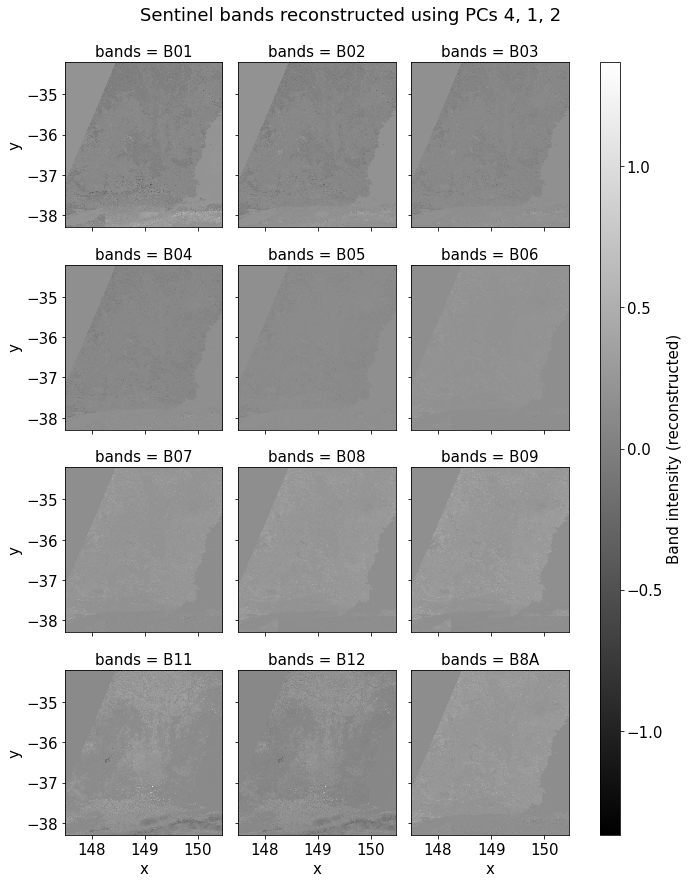

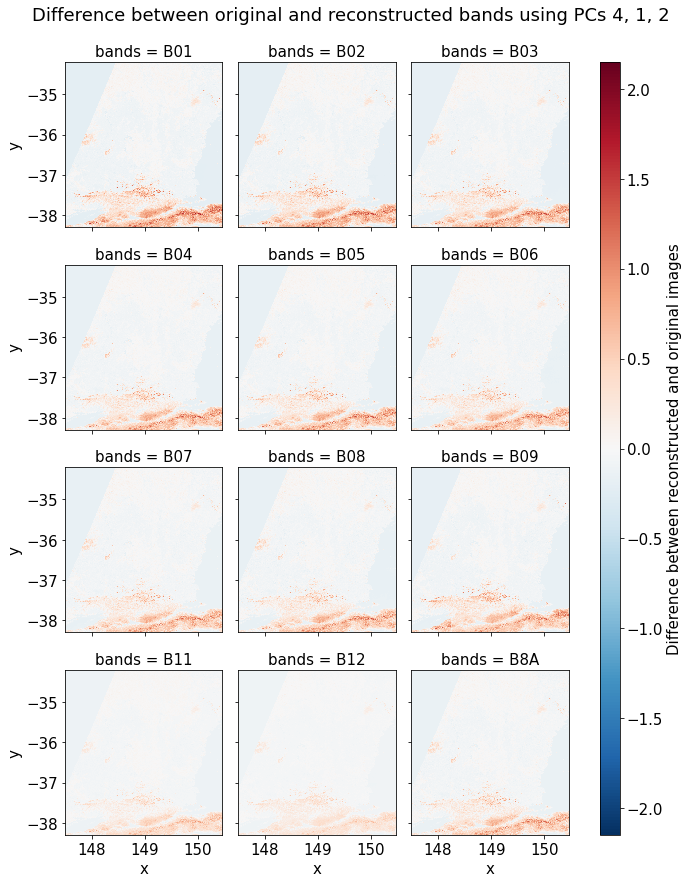

In [144]:
#----------------------------------------------------
## DEFINE THE FOLLOWING VALUES
PC_a = 4
PC_b = 1
PC_c = 2
#----------------------------------------------------

pca_3 = copy.copy(pca)
pca_3.components_ = pca_3.components_[[PC_a,PC_b,PC_c],:]

X_rec = scaler.inverse_transform(pca_3.inverse_transform(X_latent[:, [PC_a,PC_b,PC_c]]))
df_rec = pd.DataFrame(X_rec, index = df_full.index)
df_rec.columns = bands
ds_rec = df_rec.to_xarray()

# Visualize reconstructed channels 
fg=ds_rec.to_array(dim="bands").plot.imshow(col="bands", col_wrap=3, cmap="gray",cbar_kwargs={
                          "orientation": "vertical",
                          "shrink": 1,
                          "aspect": 40,
                          "label": "Band intensity (reconstructed)",
                         })
fg.fig.suptitle('Sentinel bands reconstructed using PCs %d, %d, %d'%(PC_a,PC_b,PC_c),y=1.025)


# Difference between original and reconstructed 
ds_difference = (ds_bands - ds_rec )
cbar_ax = fig.add_axes([.95, 0.15, 0.025, 0.7])
fg2 = ds_difference.to_array(dim="bands").plot.imshow(col="bands", col_wrap=3,cbar_kwargs={
                          "orientation": "vertical",
                          "shrink": 1,
                          "aspect": 40,
                          "label": "Difference between reconstructed and original images",
                         })
_ = fg2.fig.suptitle('Difference between original and reconstructed bands using PCs %d, %d, %d'%(PC_a,PC_b,PC_c),y=1.025)

> **Question 7**. What can you say about the reconstructed images? What happens if you choose different components (different values for `PC_a`, `PC_b` and `PC_c`) ? What happens if you use only two components (e.g. by setting the same value to `PC_b` and `PC_c`)?

In [145]:
# Free some memory
del df_latent, ds_latent
del df_rec, ds_rec
del ds_difference 

## 4. Unsupervised classification

In this section we will use k-means clustering to classify similar areas of the satellite
bands together. 
In the following cell, define the number of clusters you want to use to identify the land cover types accurately. Note that even if we previously were considering 6 different types, you might need to put a different number here in order to properly resolve some areas.

**Note**: k-means may take a while to run. Be patient !


In [146]:
#-----------------------------------------------------------------------------.
## Define the number of clusters you want to use.
N_CLUSTERS = 6
RANDOM_SEED = 1 # if you change this, the results will likely change ! 
N_TRAINING_SAMPLES = 20000 # to speed up training 

#-----------------------------------------------------------------------------.
# Running k-means
from sklearn.cluster import KMeans
X_norm_subset = X_norm[np.random.randint(X_norm.shape[0], size=N_TRAINING_SAMPLES),:]  
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_SEED).fit(X_norm_subset)

# Retrieve clusters
X_cluster = kmeans.predict(X_norm)
df_cluster = pd.DataFrame({'cluster': X_cluster}, index = df_full.index)
ds_cluster = df_cluster.to_xarray()
print(ds_cluster)

<xarray.Dataset>
Dimensions:  (y: 2140, x: 1250)
Coordinates:
  * y        (y) float64 -34.2 -34.21 -34.21 -34.21 ... -38.29 -38.29 -38.3
  * x        (x) float64 147.5 147.5 147.5 147.5 ... 150.5 150.5 150.5 150.5
Data variables:
    cluster  (y, x) int32 3 3 3 3 3 3 3 3 3 3 3 3 3 ... 5 2 2 2 2 2 2 2 2 2 5 2


Text(0, 0.5, 'Latitude (°)')

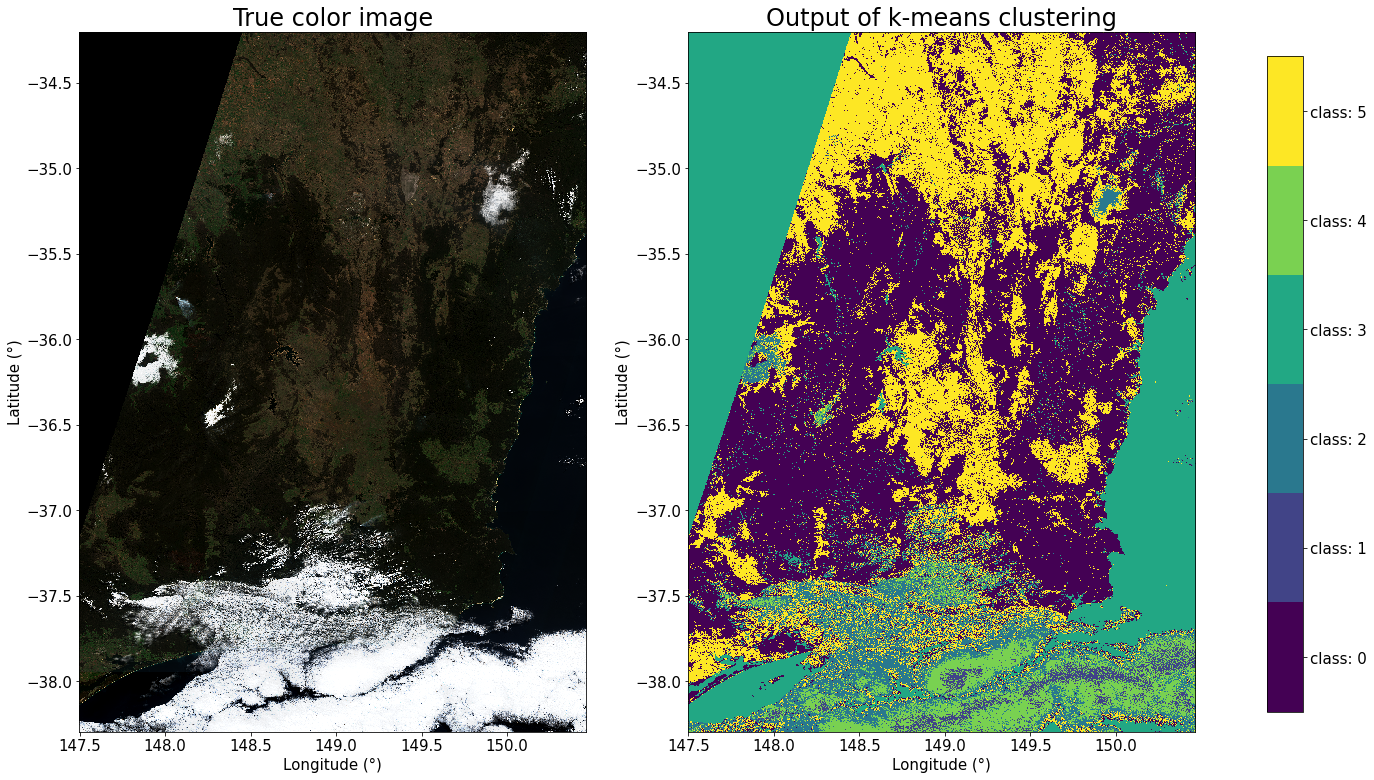

In [164]:
# Define categorical colormap 
import colorcet as cc
bounds = np.arange(0, N_CLUSTERS+1, dtype='int')
norm =  matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=N_CLUSTERS)

cbar_ticks = np.arange(0, N_CLUSTERS) + 0.5 
cbar_ticklabels = ['class: %d' % i for i in range(N_CLUSTERS)] 
cbar_kwargs={"orientation": "vertical",
              "shrink": .5,
              "aspect": 20,
              "label": " ",
              'ticks': cbar_ticks}

fig,axs = plt.subplots(1,2,figsize=(20,13))
da_true_color.plot.imshow(ax=axs[0])
cbar_ax = fig.add_axes([.95, 0.15, 0.025, 0.7])
p = ds_cluster['cluster'].plot.imshow(norm=norm,cmap='viridis',ax=axs[1],add_colorbar=0)
cb = fig.colorbar(p, cax=cbar_ax, ticks=cbar_ticks)
cb.set_ticklabels(cbar_ticklabels)

axs[0].set_aspect('equal', adjustable='box')
axs[1].set_aspect('equal', adjustable='box')

axs[0].set_title('True color image',fontsize=24)
_ = axs[1].set_title('Output of k-means clustering',fontsize=24)
axs[0].set_xlabel('Longitude (°)')
axs[1].set_xlabel('Longitude (°)')
axs[0].set_ylabel('Latitude (°)')
axs[1].set_ylabel('Latitude (°)')

> **Question 8** What is the appropriate number of clusters to distinguish properly all the land cover types? Identify the labels that would correspond to each cluster. (In your final solution, you might have several clusters corresponding to the same land cover type). \
**Note**: to answer this question, feel free to play around with the number of clusters to see how it affects the result.

## 5. Supervised Classification

In this section we move on to a new data set in the area of Lucerne.
In supervised classification, the land cover of certain areas is known. The zones need to be delimited by hand (hence the term supervised) and will serve as a training set (reference) to classify the unknown areas. 

The spectral signature determined on all Landsat bands of the training set will be used to extend the classification to the whole image.

In [172]:
# Let's clear up the workspace.
%reset -sf
import os 
import glob 
import warnings

import rioxarray
import rasterio 
import sklearn 
import colorcet
import matplotlib
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.colors as c
plt.rcParams['font.size']=15
warnings.filterwarnings('ignore')

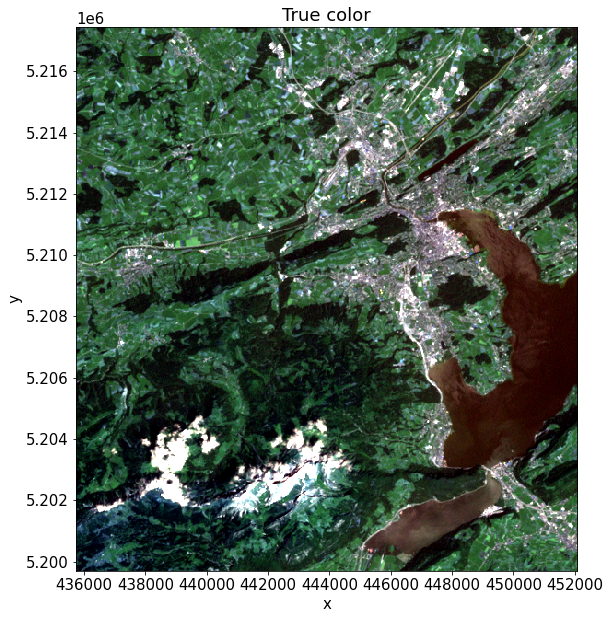

In [173]:
data_dir = "Data/Lake_Lucerne"

bands_fpattern =  "Landsat_sub_[0-9].tif"
true_color_fname = "Landsat_sub_RGB_rendered.tif"
region_bands_fname = "Landstat_4cantons.tif"
labels_fid_fname = "Rasterized_fid.tif" 
labels_mcid_fname = "Rasterized_mcid.tif" 

band_fpaths = sorted(glob.glob(os.path.join(data_dir, bands_fpattern)))
true_color_fpath = os.path.join(data_dir, true_color_fname)
region_bands_fpath = os.path.join(data_dir, region_bands_fname)
labels_fid_fpath = os.path.join(data_dir, labels_fid_fname)
labels_mcid_fpath = os.path.join(data_dir, labels_mcid_fname)

# Load bands
bands = ['C' + str(i) for i in range(1,8)]
da_bands = xr.open_mfdataset(band_fpaths, engine="rasterio", concat_dim="band", combine="nested")['band_data']
da_bands = da_bands.assign_coords({'band': bands})
da_bands = da_bands.compute()
da_bands.attrs={}
ds_bands = da_bands.to_dataset(dim="band")

# Load true color 
da_true_color = xr.open_dataset(true_color_fpath, engine="rasterio", default_name="true_color")['true_color']
da_true_color = da_true_color/255
fig = plt.figure(figsize=(10,10))
p = da_true_color.plot.imshow()
p.axes.set_aspect('equal')
_ = p.axes.set_title('True color')


In [174]:
#### Load labels  
da_labels_mcid = xr.open_dataset(labels_mcid_fpath, engine="rasterio", default_name="labels_mcid")['labels_mcid']
da_labels_mcid = da_labels_mcid.drop('band').squeeze()
da_labels_mcid = da_labels_mcid.assign_coords({'x': da_bands['x'], 'y': da_bands['y']})

da_labels_mcid.data = np.digitize(da_labels_mcid.data, np.unique(da_labels_mcid.data))
labels_dict = {"Urban": 2,
            "Water": 5, 
            "Forest": 4,
            "Agriculture": 3,
            "Bare soil": 6, 
            "Unknown": 1, 
}

labels_id_dict = {v: k for k,v in labels_dict.items()}
print(labels_id_dict)



{2: 'Urban', 5: 'Water', 4: 'Forest', 3: 'Agriculture', 6: 'Bare soil', 1: 'Unknown'}


In [175]:
# Define colormap and colorbar settings
from matplotlib import cm
cmap = cm.turbo
cmap.set_under('w',alpha=0) # to not display 1 
bounds = np.arange(2, 8, dtype='int') 
norm =  matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1,clip=False)
cbar_ticks = bounds[:-1] + 0.5
cbar_ticklabels = [labels_id_dict[i] for i in bounds[:-1]] 

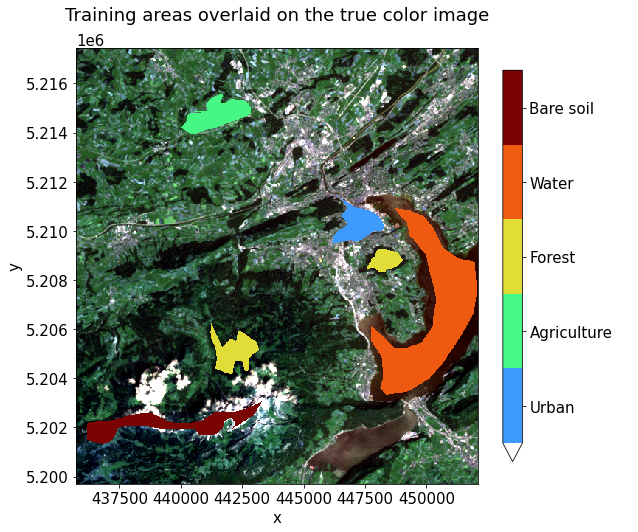

In [177]:
## TODO ADD SUBPLOT WITH ONLY TRUE COLOR

fig, ax = plt.subplots(figsize=(9,9))
# Display the true color image whichs serves as background
p = da_true_color.plot.imshow(ax=ax)
cbar_kwargs={"orientation": "vertical",
              "shrink": .8,
              "aspect": 20,
              "label": " ",
            'ticks': cbar_ticks
            }
p = da_labels_mcid.plot.imshow(ax=ax, cmap=cmap,norm=norm,cbar_kwargs=cbar_kwargs)
p.colorbar.set_ticklabels(cbar_ticklabels)
p.axes.set_title('Training areas overlaid on the true color image',y=1.05)
p.axes.set_aspect('equal')

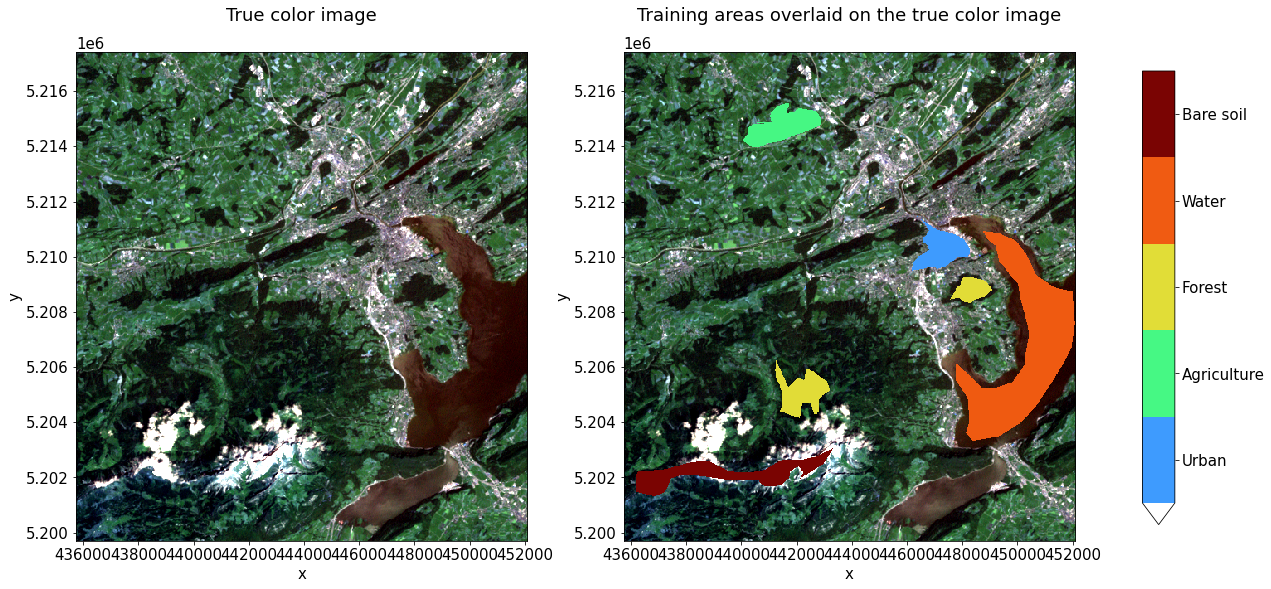

In [186]:
## TODO ADD SUBPLOT WITH ONLY TRUE COLOR

fig, axs = plt.subplots(1,2,figsize=(18,9))
# Display the true color image whichs serves as background
p = da_true_color.plot.imshow(ax=axs[0])
p = da_true_color.plot.imshow(ax=axs[1])

cbar_ax = fig.add_axes([.95, 0.15, 0.025, 0.7])
p = da_labels_mcid.plot.imshow(ax=axs[1], cmap=cmap,norm=norm,add_colorbar=0)
cb = fig.colorbar(p, cax=cbar_ax, ticks=cbar_ticks)
cb.set_ticklabels(cbar_ticklabels)

axs[0].set_title('True color image',y=1.05)
axs[1].set_title('Training areas overlaid on the true color image',y=1.05)
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')

Based on the training areas plotted above, we can calculate the spectral signature corresponding to each land cover type: we compute the median and interquantile range of the pixels within each category in the training dataset, for all the Landsat bands.\
The cell below displays these spectral signatures: mean (full line) and 10-90% quantile (shaded area) as a function of wavelength, for each of the training regions.

Text(0.5, 1.0, 'Spectral signatures')

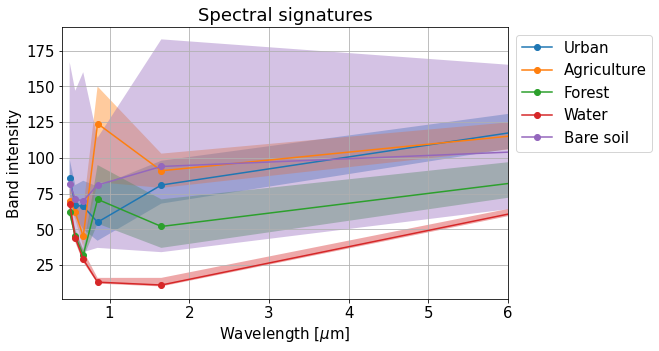

In [122]:
fig = plt.figure(figsize=(8,5))
channels = list(ds_bands.data_vars)[0:6] # exclude band 7 
wavelengths = [0.500, 0.570, 0.670, 0.850, 1.650, 11.200]
for k in range(2,7):
    class_mask = da_labels_mcid==k
    means = [np.median(ds_bands[i].data[class_mask]) for i in channels]
    q1 = [np.quantile(ds_bands[i].data[class_mask],0.1) for i in channels]
    q9 = [np.quantile(ds_bands[i].data[class_mask],0.9) for i in channels]
    plt.plot(wavelengths, means, label=labels_id_dict[k],marker='o')
    plt.fill_between(wavelengths, q1, q9,alpha=.4)
plt.xlim(0.4,6)
plt.legend(bbox_to_anchor = (1,1),loc='upper left')
plt.grid()
plt.xlabel('Wavelength [$\mu$m]')
plt.ylabel('Band intensity')
plt.title('Spectral signatures')

> **Question 9** Based on this plot and on your visual inspection (of the training areas, of the true color image), which classes are the least and the most trustworthy and why?

The following lines of code prepare the dataset for running supervised classification

In [34]:
import warnings
warnings.filterwarnings('ignore')

### Data preprocessing 
# Merge all data into xr.Dataset
ds_img = ds_bands.copy()
ds_img['labels_id'] = da_labels_mcid

# Conversion to pandas.DataFrame 
df_img = ds_img.to_dataframe()
df_img = df_img.drop(columns="spatial_ref")
df_img['labels'] = df_img['labels_id'].apply(lambda x: labels_id_dict[x])

# Remove unknown labels 
df_labelled = df_img[~df_img['labels'].isin(["Unknown"])]
print(df_labelled)

#### Define data scaling (Normalize to 0-1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler = scaler.fit(df_img[bands])

#### Define training and test set 
from sklearn.model_selection import train_test_split

# - Define predictor and target array
X = df_labelled[bands]
Y = df_labelled['labels_id'].to_numpy()

# - Random sample pixels 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

X_norm = scaler.transform(X)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

# - Define image predictors 
X_img = df_img[bands]
X_img_norm = scaler.transform(X_img)


                      C1    C2    C3     C4    C5     C6    C7  labels_id  \
y         x                                                                 
5215530.0 441570.0  67.0  58.0  38.0  143.0  83.0  140.0  35.0          3   
          441600.0  67.0  61.0  39.0  142.0  83.0  141.0  38.0          3   
          441630.0  70.0  57.0  37.0  138.0  85.0  140.0  37.0          3   
          441660.0  65.0  57.0  37.0  145.0  84.0  139.0  38.0          3   
          441690.0  67.0  58.0  39.0  141.0  84.0  138.0  39.0          3   
...                  ...   ...   ...    ...   ...    ...   ...        ...   
5201370.0 436920.0  69.0  61.0  57.0   86.0  95.0  143.0  57.0          6   
5201340.0 436770.0  58.0  47.0  38.0   64.0  55.0  127.0  31.0          6   
          436800.0  60.0  49.0  38.0   71.0  62.0  130.0  35.0          6   
          436830.0  64.0  56.0  48.0   80.0  83.0  135.0  46.0          6   
          436860.0  69.0  63.0  61.0   88.0  96.0  140.0  52.0          6   

The next cell runs supervised classification using several different methods: Logistic Regression, Gaussian Naive Bayes, K-nearest neighbors, Random Forest

In [35]:
#### Train Multinomial Logistic Regression  
from sklearn.linear_model import LogisticRegression
# if multinomial --> cross-entropy loss 
# if ovr --> “one-vs-the-rest” multi-class approach

logistic_model = LogisticRegression(random_state=0,
                                    multi_class="ovr")
logistic_model.fit(X_train_norm, Y_train)

#### Train Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()    
nb_model.fit(X_train_norm, Y_train)

#### Train KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
n_neighbors=5
knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_model.fit(X_train_norm, Y_train)

#### Train Random Forest 
from sklearn.ensemble import RandomForestClassifier
n_trees = 10 # increase to improve accuracy (but increase training time)
rf_model = RandomForestClassifier(n_estimators=n_trees, 
                                  criterion='gini',
                                  max_depth=30, 
                                  min_samples_split=2, 
                                  min_samples_leaf=1,
                                  random_state=0)
rf_model.fit(X_train_norm, Y_train)

#### Define dictionary of trained models 
dict_models = {'LG': logistic_model,
               'NB': nb_model, 
               'RF': rf_model, 
               'KNN': knn_model
               }
print(dict_models)


{'LG': LogisticRegression(multi_class='ovr', random_state=0), 'NB': GaussianNB(), 'RF': RandomForestClassifier(max_depth=30, n_estimators=10, random_state=0), 'KNN': KNeighborsClassifier()}


And now we implement the classifier on our data. It can take a bit of time ...

In [36]:
### Predict class 
dict_pred = {model_acronym: model.predict(X_img_norm) for model_acronym, model in  dict_models.items()}
df_pred = pd.DataFrame(dict_pred, index = df_img.index)
ds_pred = df_pred.to_xarray()
print(ds_pred)

<xarray.Dataset>
Dimensions:  (y: 591, x: 545)
Coordinates:
  * y        (y) float64 5.217e+06 5.217e+06 5.217e+06 ... 5.2e+06 5.2e+06
  * x        (x) float64 4.358e+05 4.358e+05 4.358e+05 ... 4.52e+05 4.521e+05
Data variables:
    LG       (y, x) int64 4 4 4 4 3 6 6 6 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3 3 3 3
    NB       (y, x) int64 4 4 4 4 3 3 6 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3 3 3 3
    RF       (y, x) int64 4 4 4 4 3 6 6 6 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3 3 3 3
    KNN      (y, x) int64 4 4 6 4 3 6 6 6 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3 3 3 3


In [37]:
# Define colormap and colorbar 
from matplotlib import cm
cmap = cm.turbo
bounds = np.arange(1, 8, dtype='int') # [1,2,3,4,5,6,7]
norm =  matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1, clip=False)
cbar_ticks = bounds[:-1] + 0.5
cbar_ticklabels = [labels_id_dict[i] for i in bounds[:-1]] 

cbar_kwargs={"orientation": "vertical",
              "shrink": 1,
              "aspect": 30,
              "label": " ",
             'ticks': cbar_ticks
            }

And we plot the result:

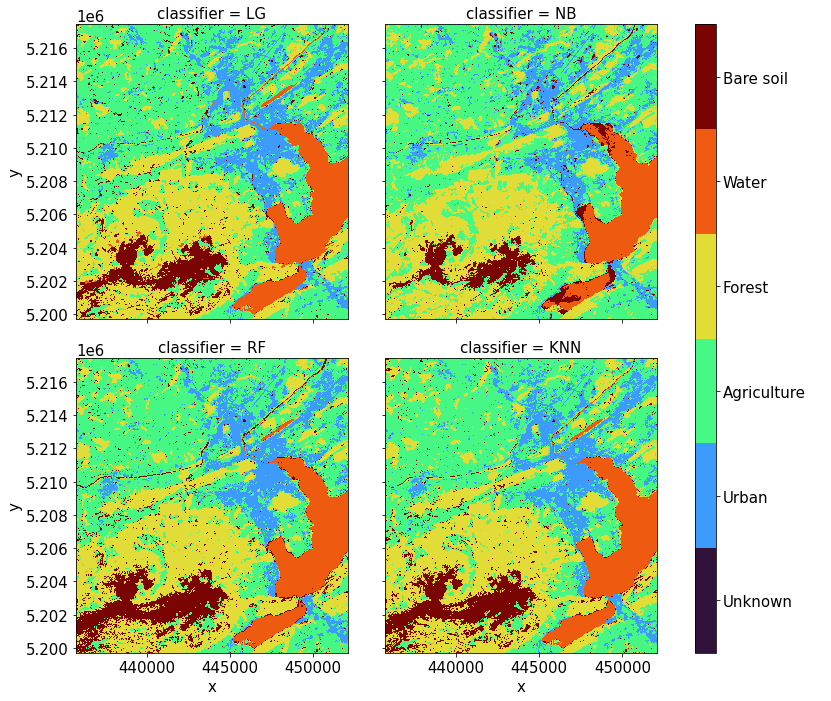

In [38]:
# Plot the model predictions images
p = ds_pred.to_array(dim="classifier").plot.imshow(col="classifier", col_wrap=2,
                                                   figsize=(12,10),cmap=cmap,norm=norm,cbar_kwargs=cbar_kwargs)
for ax in p.axes.flatten():
    ax.set_aspect('equal')
p.cbar.set_ticklabels(cbar_ticklabels)

**Ground truth**:\
The performance of a classifier is typically evaluated by comparing the classified image with a ground truth which refers to information that is directly observed from the ground, and that is supposed to be as close to the truth as possible. 

In our case, we will use information derived from the Swiss land cover statistic NOAS09. 
The Swiss land cover statistics consists of a 250x250 m 2 resolution raster over Switzerland classified into 17 land cover types. The classification is done manually by observation of aerial photographs.

Here we provide the ground truth obtained by reclassifying the original 17 land cover classes into the 5 considered classes (Urban, Agriculture, Forest, Water and Bare soil).

Compare it quickly with the output of your classifications.  

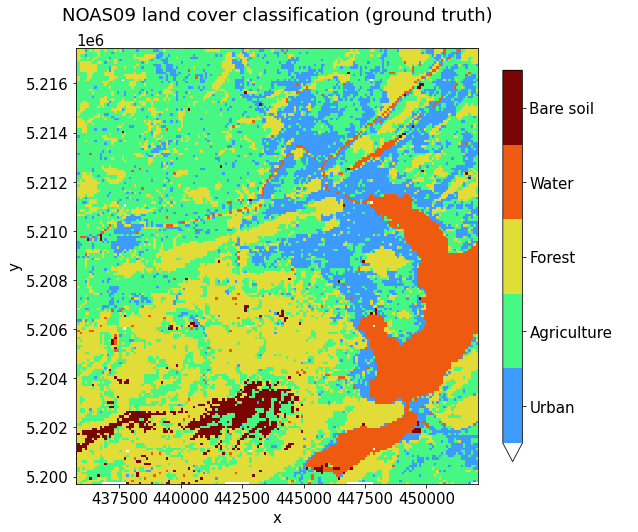

In [39]:
da_labels_mcid_true = xr.open_dataset('Data/Lake_Lucerne/test_NOAS.tif', engine="rasterio", default_name="labels_mcid_true")['labels_mcid_true']
da_labels_mcid_true = da_labels_mcid_true.where(da_labels_mcid_true == da_labels_mcid_true, -1)
da_labels_mcid_true = da_labels_mcid_true +1
da_labels_mcid_true = da_labels_mcid_true.drop('band').squeeze() #We add 1 because the labels in this tif are shifted by 1.
da_labels_mcid_true = da_labels_mcid_true.assign_coords({'x': da_bands['x'], 'y': da_bands['y']})

da_labels_mcid_true.data = np.digitize(da_labels_mcid_true.data, np.unique(da_labels_mcid_true.data))


fig = plt.figure(figsize=(9,9))
bounds = np.arange(1, 7, dtype='int')+.5
norm =  matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=5,clip=False)
from matplotlib import cm
cmap = cm.turbo
# cmap.set_under('w',alpha=0)
cbar_ticks = np.arange(2, 7) #+ 0.5 
cbar_ticklabels = [labels_id_dict[i] for i in range(2,7)] 

cbar_kwargs={"orientation": "vertical",
             "shrink": .8,
             "aspect": 20,
             "label": " ",
             "ticks": cbar_ticks
            }
p = da_labels_mcid_true.plot.imshow(vmin=1.5,cmap=cmap,norm=norm,cbar_kwargs=cbar_kwargs)
p.colorbar.set_ticklabels(cbar_ticklabels)
p.axes.set_title('NOAS09 land cover classification (ground truth)',y=1.05)
p.axes.set_aspect('equal')

Using this NOAS09 land cover as a reference, we compute the mean accuracy on the test set (which was selected as a subset of the data)

In [40]:
#### Mean accuracy on test set 
lg_accuracy = logistic_model.score(X_test_norm, Y_test)
knn_accuracy = knn_model.score(X_test_norm, Y_test)
nb_accuracy = nb_model.score(X_test_norm, Y_test)
rf_accuracy = rf_model.score(X_test_norm, Y_test)
dict_accuracy = {'RF': rf_accuracy, 
                 'NB': nb_accuracy, 
                 'LG': lg_accuracy, 
                 'KNN': knn_accuracy}
print(dict_accuracy)

{'RF': 0.9830548364321017, 'NB': 0.9056248529065662, 'LG': 0.9550482466462697, 'KNN': 0.9827018121911038}


By looking at both your classification images and the ground truth, and using the accuracy metrics that were just computed, answer the following questions.

> **Question 10**: Investigate the mis-classifications. Are there systematic issues with some land cover types? What are possible sources of these errors? 

> **Question 11**: Compare the results from the different classifiers. Which classifier would you choose?

> **Question 12**: Compare this to your experiences with the unsupervised classification in Australia. What are the advantages and disadvantages?

We take this a step further, and plot the probability associated with the prediction of a given classifier.


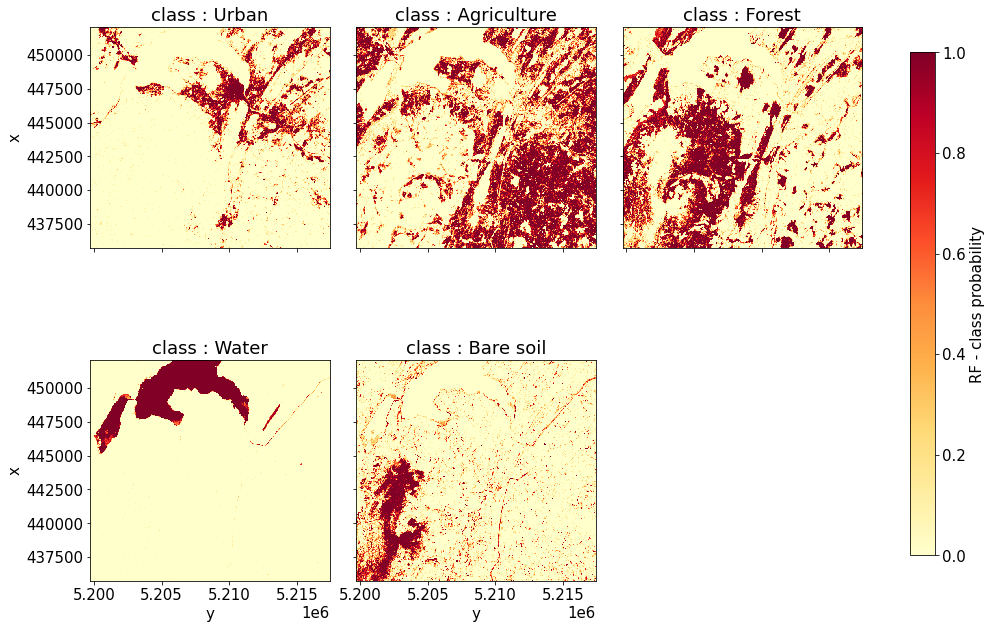

In [42]:
### Predict class probability
dict_prob = {model_acronym: model.predict_proba(X_img_norm) for model_acronym, model in  dict_models.items()}
list_da = []
for key, prob in dict_prob.items(): 
    df_prob = pd.DataFrame(prob, index = df_pred.index)
    df_prob.columns = np.arange(1, df_prob.columns.stop+1)
    ds_prob = df_prob.to_xarray().to_array('class')
    ds_prob.name = key
    list_da.append(ds_prob)
ds_prob = xr.merge(list_da)
ds_prob['class_name'] = ['Urban', 'Agriculture', 'Forest', 'Water', 'Bare_soil']

# - Plot prob for each class (and single model)
cbar_kwargs={"orientation": "vertical",
              "shrink": .8,
              "aspect": 20,
             "label": "RF - class probability"
            }
p=ds_prob['RF'].T.plot.imshow(col="class", col_wrap=3,cmap='YlOrRd',figsize=(15,10),cbar_kwargs=cbar_kwargs)
for ax in p.axes.flatten():
    ax.set_aspect('equal')
p.axes[0,0].set_title('class : Urban')
p.axes[0,1].set_title('class : Agriculture')
p.axes[0,2].set_title('class : Forest')
p.axes[1,0].set_title('class : Water')
_=p.axes[1,1].set_title('class : Bare soil')

> **Question 13**: How do you interpret this figure?

For your information, we can now select the classifier which perform best and classify a larger region (following cells).

In [43]:
BEST_MODEL_KEY = "RF"

# Open image with large region 
da_bands_region = xr.open_dataset(region_bands_fpath, engine="rasterio", default_name="bands")['bands']
da_bands_region = da_bands_region.assign_coords({'band':  ['C' + str(i) for i in range(1,8)]})
ds_bands_region = da_bands_region.to_dataset(dim="band")

# Conversion to pandas.DataFrame 
df_region = ds_bands_region.to_dataframe()

# - Define predictor array
X_region = df_region[bands]
X_region_norm = scaler.transform(X_region)

# - Retrieve best model 
best_model = dict_models[BEST_MODEL_KEY]

# - Predict classes
df_region_pred = pd.DataFrame({BEST_MODEL_KEY: best_model.predict(X_region_norm)}, index = df_region.index)
ds_region_pred = df_region_pred.to_xarray()
print(ds_region_pred)


<xarray.Dataset>
Dimensions:  (y: 1887, x: 2008)
Coordinates:
  * y        (y) float64 5.244e+06 5.244e+06 5.243e+06 ... 5.187e+06 5.187e+06
  * x        (x) float64 4.323e+05 4.324e+05 4.324e+05 ... 4.925e+05 4.925e+05
Data variables:
    RF       (y, x) int64 3 3 3 3 3 3 3 3 3 6 3 3 3 ... 6 6 6 6 6 6 6 6 6 6 6 6


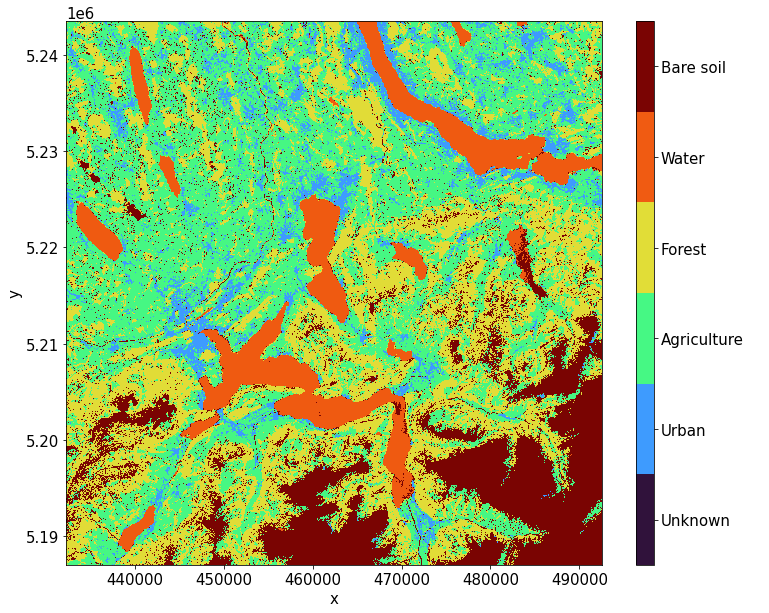

In [44]:
# Define colormap and colorbar 
from matplotlib import cm
cmap = cm.turbo
bounds = np.arange(1, 8, dtype='int') # [1,2,3,4,5,6,7]
norm =  matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1, clip=False)
cbar_ticks = bounds[:-1] + 0.5
cbar_ticklabels = [labels_id_dict[i] for i in bounds[:-1]] 

cbar_kwargs={"orientation": "vertical",
              "shrink": 1,
              "aspect": 30,
              "label": " ",
             'ticks': cbar_ticks
            }

# Display the classified image 
p = ds_region_pred[BEST_MODEL_KEY].plot.imshow(figsize=(12,10),cmap=cmap,norm=norm,cbar_kwargs=cbar_kwargs)
p.colorbar.set_ticklabels(cbar_ticklabels)